In [92]:
from flytracker.utils import FourArenasQRCodeMask
from torch.utils.data import DataLoader
from flytracker.dataset import VideoDataset

from sklearn.cluster import KMeans

import torch
import matplotlib.pyplot as plt

In [93]:
# Getting image sample
mask = FourArenasQRCodeMask().mask
path = "/home/gert-jan/Documents/flyTracker/data/movies/4arenas_QR.h264"

dataset = VideoDataset(path, mask)
loader = DataLoader(dataset, batch_size=1, pin_memory=True)
iterator = iter(loader)
data = iterator.next()
data = data.type(torch.float32).squeeze()

In [94]:
# First we standardize data
X = (data - torch.mean(data, dim=0)) / torch.std(data, dim=0)
n_clusters = 40 
n_samples = X.shape[0]

In [97]:
%%timeit
# Let's set a common starting point
init = KMeans(n_clusters=n_clusters, n_init=1, algorithm='full', max_iter=1, random_state=20).fit(X).cluster_centers_

11.4 ms ± 325 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [98]:
init.shape

(40, 2)

In [99]:
%%time
# Let's use sklearn api to get a baseline for speed etc
# Just 1 initiliazation etc to get the implementation right
kmeans = KMeans(n_clusters=40, n_init=1, algorithm='full', init=init).fit(X).cluster_centers_

CPU times: user 18.7 ms, sys: 0 ns, total: 18.7 ms
Wall time: 5.55 ms


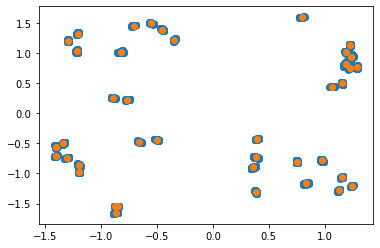

In [100]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(kmeans[:, 0], kmeans[:, 1])

In [101]:
class KMeans_torch():
    def __init__(self, n_clusters, init, device, tol=1e-4):
        self.n_clusters = n_clusters
        self.tol = tol
        self.init = init
        self.device = device
        
    def fit(self, X):
        self.n_samples = X.shape[0]
        self.M = torch.zeros((self.n_clusters, self.n_samples)).to(self.device)
        
        cluster_centers, cluster_centers_old = self.em_step(X, self.init)[0], self.init
        
        while torch.norm(cluster_centers - cluster_centers_old) > self.tol:
            cluster_centers, cluster_centers_old = self.em_step(X, cluster_centers)[0], cluster_centers
        
        return self.em_step(X, cluster_centers)
    
    def em_step(self, X, cluster_centers):
        # E step
        dist_matrix = torch.cdist(X, cluster_centers)
        labels = torch.min(dist_matrix, dim=1).indices
    
        # M step
        self.M.zero_()
        self.M[labels, torch.arange(self.n_samples)] = 1
        self.M = torch.nn.functional.normalize(M, p=1, dim=1)
        cluster_centers = M @ X
        
        return cluster_centers, labels

In [102]:
def kmeans_torch(X, cluster_centers):
    n_samples = X.shape[0]
    n_clusters = cluster_centers.shape[0]
    
    # E step
    dist_matrix = torch.cdist(X, cluster_centers)
    labels = torch.min(dist_matrix, dim=1).indices
    
    # M step
    M = torch.zeros((n_clusters, n_samples)).to(X.device)
    M = torch.cuda.FloatTensor(n_clusters, n_samples).fill_(0)
    M[labels, torch.arange(n_samples)] = 1
    
    cluster_centers = M @ X
    return cluster_centers, labels

In [103]:
device='cuda'

In [104]:
# %% Using sklearn initialization
X = X.to(device)
cluster_centers = torch.tensor(init, dtype=torch.float32).to(device)
cluster_centers, cluster_centers_old = kmeans_torch(X, cluster_centers)[0], cluster_centers

In [21]:
%%time
while torch.norm(cluster_centers - cluster_centers_old) > 1e-4:
    cluster_centers, cluster_centers_old = kmeans_torch(X, cluster_centers)[0], cluster_centers

CPU times: user 967 µs, sys: 20 ms, total: 21 ms
Wall time: 22.4 ms


In [28]:
reg = KMeans_torch(n_clusters=40, init=torch.tensor(init, dtype=torch.float32).to(device), device=device)

In [29]:
%%time
centres, label = reg.fit(X)

NameError: name 'M' is not defined

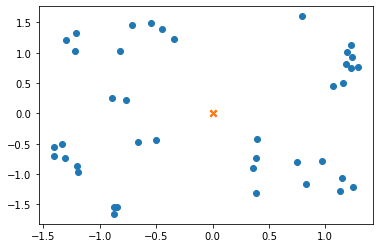

In [26]:
#plt.scatter(X[:, 0].cpu(), X[:, 1].cpu())
plt.scatter(kmeans[:, 0], kmeans[:, 1], marker='o')
plt.scatter(cluster_centers[:, 0].cpu(), cluster_centers[:, 1].cpu(), marker='x')

In [27]:
X.zero_()

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')

# Jax version

In [34]:
import jax
import jax.numpy as jnp
from jax.scipy.sp

In [67]:
def cdist(x, y):
    return jnp.linalg.norm(x[:, None, ] - y[None, :, :], axis=-1)

In [68]:
X = jnp.array(X.cpu())
cluster_centers = init

AttributeError: '_DeviceArray' object has no attribute 'cpu'

In [107]:
@jax.jit
def kmeans_jax(X, cluster_centers):
    n_samples = X.shape[0]
    n_clusters = cluster_centers.shape[0]
    
    # E step
    dist_matrix = cdist(X, cluster_centers)
    labels = jnp.argmin(dist_matrix, axis=1)
    
    # Mstep
    M = jnp.zeros((n_clusters, n_samples))
    M = jax.ops.index_update(M, (labels, jnp.arange(n_samples)), 1.0)
    new_cluster_centers = M @ X
    return new_cluster_centers, labels

In [108]:
cluster_centers, labels = kmeans_jax(X, cluster_centers)

TypeError: Argument 'tensor([[-0.8969, -1.6729],
        [-0.8927, -1.6729],
        [-0.8886, -1.6729],
        ...,
        [ 0.8102,  1.6159],
        [ 0.8143,  1.6159],
        [ 0.8184,  1.6159]], device='cuda:0')' of type <class 'torch.Tensor'> is not a valid JAX type

In [109]:
%%timeit
kmeans_jax(X, cluster_centers)

TypeError: Argument 'tensor([[-0.8969, -1.6729],
        [-0.8927, -1.6729],
        [-0.8886, -1.6729],
        ...,
        [ 0.8102,  1.6159],
        [ 0.8143,  1.6159],
        [ 0.8184,  1.6159]], device='cuda:0')' of type <class 'torch.Tensor'> is not a valid JAX type